# The Projected Power Spectrum of Data in a Simulation Box

In this notebook, we explore the functionality of the ``ProjectedFFTPower`` algorithm, which can compute the power spectrum of density fields projected in 1D and 2D, commonly referred to as $P_\mathrm{1D}(k)$ and $P_\mathrm{2D}(k)$.  The algorithm is suitable for use on data sets in periodic simulation boxes, as the power spectrum is computed via a single FFT of the projected density mesh. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from nbodykit.lab import *
from nbodykit import setup_logging, style

import matplotlib.pyplot as plt
plt.style.use(style.notebook)

In [3]:
setup_logging()

## Initalizing a Log-normal Mock

We start by generating a mock catalog of biased objects ($b_1 = 2$ ) at a redshif $z=0.55$. We use the *Planck* 2015 cosmology and the Eisenstein-Hu linear power spectrum fitting formula. We generate the catalog in a box of side length $L = 1380 \ \mathrm{Mpc}/h$ with a constant number density $\bar{n} = 3 \times 10^{-3} \ h^{3} \mathrm{Mpc}^{-3}$.

In [4]:
redshift = 0.55
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
BoxSize = 1380.
b1 = 2.0

cat = LogNormalCatalog(Plin=Plin, nbar=3e-3, BoxSize=BoxSize, Nmesh=256, bias=b1, seed=42)

We update the ``Position`` column to add redshift-space distortions along the ``z`` axis of the box using the ``VelocityOffset`` column.

In [5]:
# add RSD
line_of_sight = [0,0,1]
cat['Position'] += cat['VelocityOffset'] * line_of_sight

## Computing the Projected Power

In this section, we compute and plot the power spectra of the projected 1D and 2D density fields, and compare to the full 3D power spectrum.  

We must first convert our ``CatalogSource`` object to a ``MeshSource``, by setting up the mesh and specifying which interpolation kernel we wish to use. Here, we use "TSC" interpolation, and specify via ``compensated=True`` that we wish to correct for the effects of the interpolation window in Fourier space.

In [6]:
# convert to a MeshSource, using TSC interpolation on 256^3 mesh
mesh = cat.to_mesh(window='tsc', Nmesh=256, compensated=True)

We compute the 2D projected power by specifying that we wish to project the density field on to the ``(x,y)`` plane by passing ``axes=[0,1]`` to ``ProjectedFFTPower``.

In [7]:
# the projected 2D power
r_2d = ProjectedFFTPower(mesh, dk=0.005, kmin=0.01, axes=[0,1])

[ 000019.26 ]   0: 10-23 09:43  CatalogMesh     INFO     painted 7887677 out of 7887677 objects to mesh


[ 000019.26 ]   0: 10-23 09:43  CatalogMesh     INFO     mean particles per cell is 0.470142


[ 000019.26 ]   0: 10-23 09:43  CatalogMesh     INFO     sum is 7.88768e+06 


[ 000019.26 ]   0: 10-23 09:43  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000019.62 ]   0: 10-23 09:43  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


We compute the 1D projected power by specifying that we wish to project the density field on to the ``x`` plane by passing ``axes=[0]`` to ``ProjectedFFTPower``.

In [8]:
# the projected 1D power
r_1d = ProjectedFFTPower(mesh, dk=0.005, kmin=0.01, axes=[0])

[ 000025.97 ]   0: 10-23 09:43  CatalogMesh     INFO     painted 7887677 out of 7887677 objects to mesh


[ 000025.97 ]   0: 10-23 09:43  CatalogMesh     INFO     mean particles per cell is 0.470142


[ 000025.97 ]   0: 10-23 09:43  CatalogMesh     INFO     sum is 7.88768e+06 


[ 000025.97 ]   0: 10-23 09:43  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000026.35 ]   0: 10-23 09:43  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


We also use the ``FFTPower`` algorithm to compute the power spectrum of the full 3D density field for comparison purposes.

In [9]:
# the 3D power P(k)
r_3d = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)

[ 000032.14 ]   0: 10-23 09:43  CatalogMesh     INFO     painted 7887677 out of 7887677 objects to mesh


[ 000032.15 ]   0: 10-23 09:43  CatalogMesh     INFO     mean particles per cell is 0.470142


[ 000032.15 ]   0: 10-23 09:43  CatalogMesh     INFO     sum is 7.88768e+06 


[ 000032.15 ]   0: 10-23 09:43  CatalogMesh     INFO     normalized the convention to 1 + delta


[ 000032.50 ]   0: 10-23 09:43  CatalogMesh     INFO     field: (LogNormalCatalog(seed=42, bias=2) as CatalogMesh) painting done


The power spectrum results are stored as a ``BinnedStatistic`` object as the ``power`` attribute. 

In [10]:
# the result is stored at "power" attribute
P1D = r_1d.power
P2D = r_2d.power
P3D = r_3d.power

Here, we plot each of the measured power spectra, scaled appropriately by the box size $L_\mathrm{box}$ in order to have the same units for each power spectra. 

(0.01, 0.6)

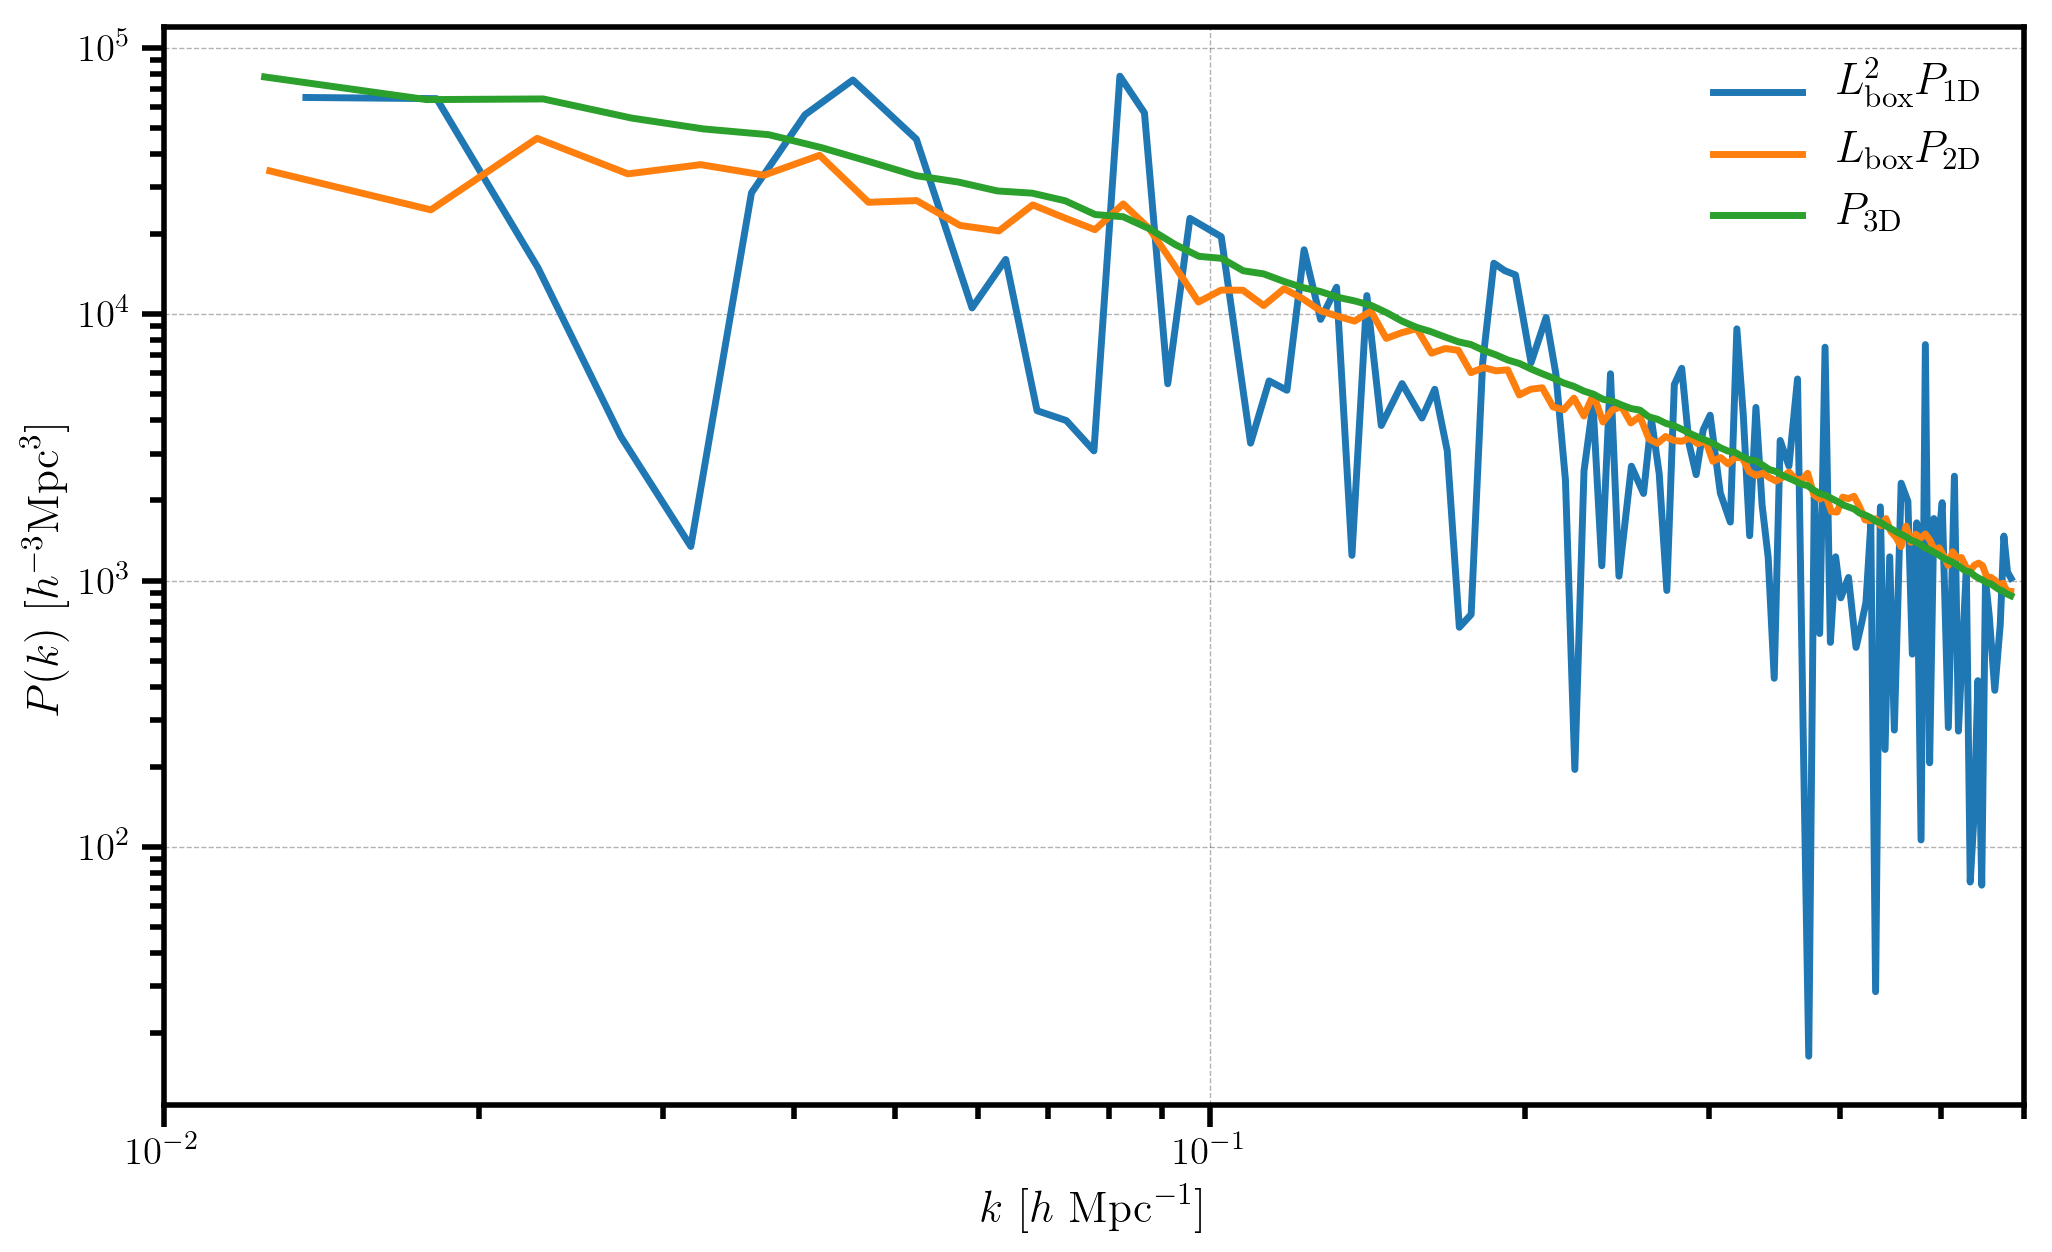

In [11]:
# plot the 1D, 2D, and 3D power spectra
plt.loglog(P1D['k'], P1D['power'].real * BoxSize**2, label=r'$L_\mathrm{box}^2 P_\mathrm{1D}$')
plt.loglog(P2D['k'], P2D['power'].real * BoxSize, label=r"$L_\mathrm{box} P_\mathrm{2D}$")
plt.loglog(P3D['k'], P3D['power'].real, label=r"$P_\mathrm{3D}$")

# format the axes
plt.legend(loc=0)
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$ [$h^{-3}\mathrm{Mpc}^3$]")
plt.xlim(0.01, 0.6)

We can see that $P_\mathrm{1D}$ and $P_\mathrm{2D}$ are considerably noisier than the 3D power spectrum, which results from the fact that the number of Fourier modes to average over in each bin is drastically reduced when averaging the fields over certain axes. 